In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [39]:
path = '../pure_excel/pure_excel_khin.xlsx'
df = pd.read_excel(path, sheet_name='good_base')
df.sample(3)

,name,measures,year,quarter,month,month_num,value
4077,VALSAFORCE PHARM-CENTER,Volume Treatment Days,2012,Q1,Jan,1,"53,742.26"
1802,LAZARTAN GEDEON RICHTER,Volume Treatment Days,2013,Q1,Jan,1,"25,029.69"
3844,VALSACOR KRKA,Value Trade RUB,2012,Q3,Aug,8,"10,124,813.36"


# EDA

In [41]:
# Проверяем есть ли пропущенные значения

df.isna().sum()

name         0
measures     0
year         0
quarter      0
month        0
month_num    0
value        0
dtype: int64

In [47]:
# Проверяем целостность временной шкалы на пропущенные периоды

month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
df[['year', 'month']].drop_duplicates().sort_values(['year', 'month'])

,year,month
117,2010,Jan
118,2010,Feb
119,2010,Mar
120,2010,Apr
121,2010,May
122,2010,Jun
123,2010,Jul
124,2010,Aug
125,2010,Sep
126,2010,Oct


In [69]:
# Проверка на отрицательность. По бизнес-логике значений меньше нуля быть не должно. Так и есть.
df.value.describe()

count         4,794.00
mean      5,856,328.08
std      21,638,751.55
min               0.00
25%          27,485.22
50%         247,329.00
75%       1,182,195.00
max     346,515,008.75
Name: value, dtype: float64

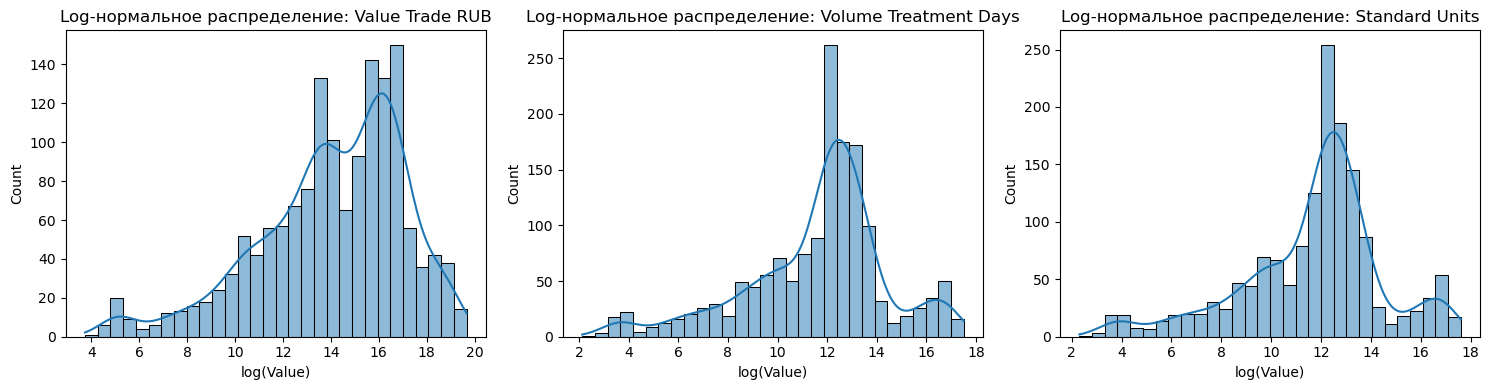

In [67]:
measures = ['Value Trade RUB', 'Volume Treatment Days', 'Standard Units']
plt.figure(figsize=(15, 4))

for i, measure in enumerate(measures, 1):
    plt.subplot(1, 3, i)
    
    df_measure = df[df['measures'] == measure]
    values = df_measure['value']
    values = values[values > 0]
    log_values = np.log(values)
    
    sns.histplot(log_values, bins=30, kde=True)
    plt.title(f'Log-нормальное распределение: {measure}')
    plt.xlabel('log(Value)')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Market Attractiveness

In [82]:
dynamic = (
    df[df.measures.isin(['Value Trade RUB', 'Standard Units'])]
    .groupby(['name', 'measures', 'year'])
    .agg({'value':sum})
    .unstack('measures')
    .reset_index()
)
dynamic.columns = ['name', 'year', 'qty', 'amt']
dynamic = dynamic[['name', 'year', 'amt', 'qty']].assign(average_price=lambda x: x.amt / x.qty).fillna(0)

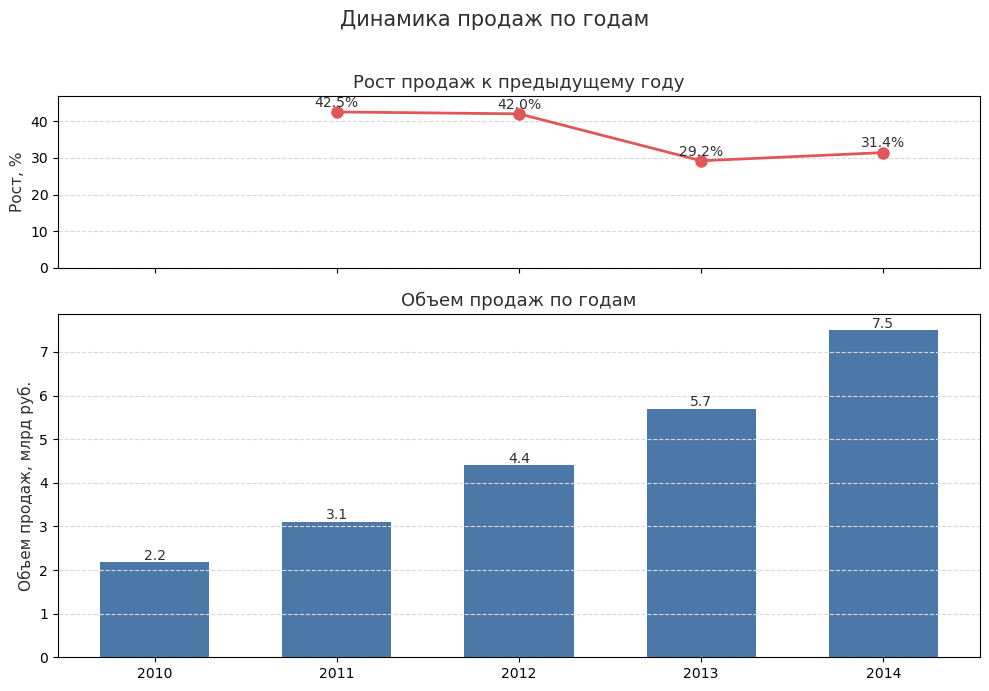

In [109]:
yearly_sales = dynamic.groupby('year')['amt'].sum().reset_index()
yearly_sales['growth_pct'] = (yearly_sales['amt'] / yearly_sales['amt'].shift(1) - 1) * 100

bar_color  = '#4C78A8'
line_color = '#E15759'
text_color = '#2F2F2F'
grid_color = '#D9D9D9'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True,
                               gridspec_kw={'height_ratios': [1, 2]})
plt.subplots_adjust(hspace=0.35)

ax1.plot(yearly_sales['year'], yearly_sales['growth_pct'],
         color=line_color, marker='o', markersize=8, linewidth=2)

ymax = yearly_sales['growth_pct'].max() * 1.1
ax1.set_ylim(0, ymax)

for x, y in zip(yearly_sales['year'], yearly_sales['growth_pct']):
    if not np.isnan(y):
        ax1.text(x, y + ymax*0.03, f"{y:.1f}%", ha='center',
                 fontsize=10, color=text_color)

ax1.set_ylabel('Рост, %', fontsize=11, color=text_color)
ax1.grid(axis='y', linestyle='--', color=grid_color)
ax1.set_title('Рост продаж к предыдущему году', fontsize=13, color=text_color)

bars = ax2.bar(yearly_sales['year'], yearly_sales['amt'] / 1e9,
               color=bar_color, width=0.6)

for bar in bars:
    h = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, h + 0.05,
             f"{h:.1f}", ha='center', fontsize=10, color=text_color)

ax2.set_ylabel('Объем продаж, млрд руб.', fontsize=11, color=text_color)
ax2.grid(axis='y', linestyle='--', color=grid_color)
ax2.set_title('Объем продаж по годам', fontsize=13, color=text_color)

fig.suptitle('Динамика продаж по годам', fontsize=15, color=text_color, y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

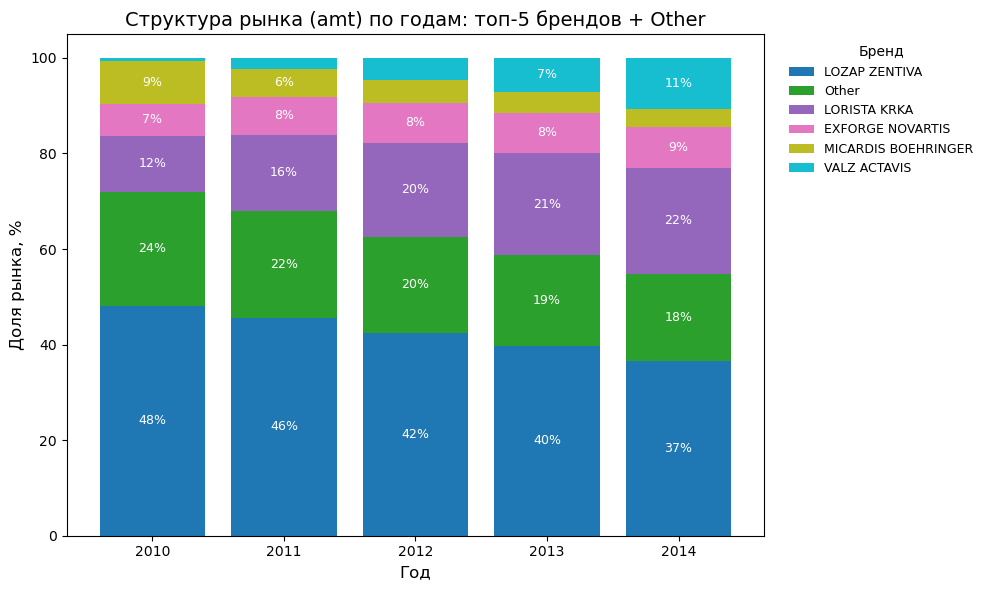

In [115]:
top5 = (
    dynamic.groupby('name')['amt']
           .sum()
           .nlargest(5)
           .index
           .tolist()
)
dynamic['brand_top5'] = dynamic['name'].where(dynamic['name'].isin(top5), 'Other')

# 2. Сводная таблица: строки — годы, столбцы — топ‑5 + Other
pivot = (
    dynamic
    .groupby(['year', 'brand_top5'])['amt']
    .sum()
    .unstack(fill_value=0)
)

# 3. Переводим в процентные доли
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

# 4. Сортируем годы по возрастанию (от 2010 к 2014)
pivot_pct = pivot_pct.sort_index()

# 5. Сортируем столбцы так, чтобы самый крупный бренд был внизу (bottom)
col_order = pivot_pct.sum(axis=0).sort_values(ascending=False).index
pivot_pct = pivot_pct[col_order]

# 6. Рисуем 100% stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

pivot_pct.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=0.8,
    cmap='tab10'
)

# 7. Оформление
ax.set_xlabel('Год', fontsize=12)
ax.set_ylabel('Доля рынка, %', fontsize=12)
ax.set_title('Структура рынка (amt) по годам: топ‑5 брендов + Other', fontsize=14)
ax.set_xticklabels(pivot_pct.index, rotation=0)

# 8. Подписи процентов в сегментах (для долей ≥ 5%)
for i, year in enumerate(pivot_pct.index):
    left = 0
    for brand in pivot_pct.columns:
        pct = pivot_pct.loc[year, brand]
        if pct >= 5:
            ax.text(
                i,
                left + pct/2,
                f'{pct:.0f}%',
                ha='center',
                va='center',
                fontsize=9,
                color='white'
            )
        left += pct

# Легенда справа
ax.legend(
    title='Бренд',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=False,
    fontsize=9
)

plt.tight_layout()
plt.show()